In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Grey Image:


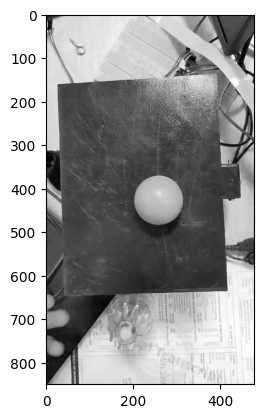

Blur Image:


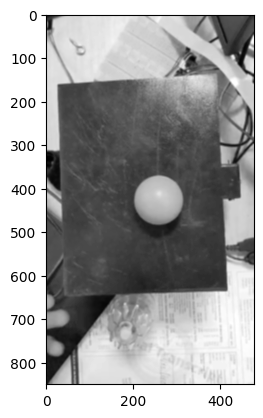

Threshold Image:


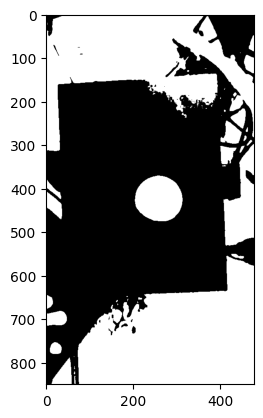

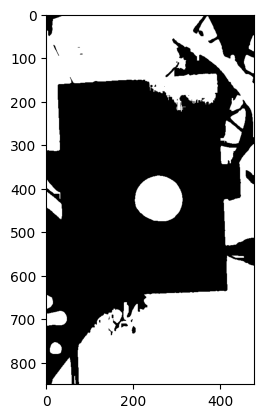

Number of Rectangles:  28
Number of contours:  62
Contour Area:  8847.0


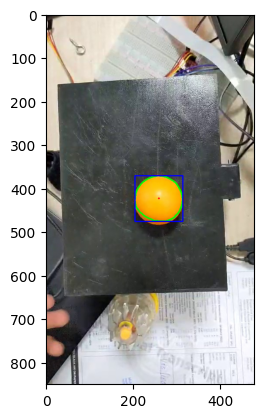

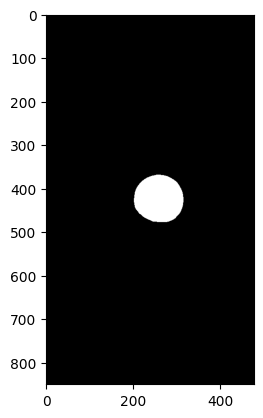

In [88]:
image = cv2.imread('frames/frame_16.jpg')
kernel_size=5
area_min=2000
area_max=10000

grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("Grey Image:")
plt.imshow(grey_image, cmap='gray')
plt.show()

gauss_image = cv2.GaussianBlur(grey_image, (kernel_size, kernel_size), sigmaX=5, sigmaY=5)
print("Blur Image:")
plt.imshow(gauss_image, cmap='gray')
plt.show()

threshold_image = cv2.threshold(gauss_image, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
threshold_image = 255 - threshold_image[1]
print("Threshold Image:")
plt.imshow(threshold_image, cmap='gray')
plt.show()

line_min_width = 15
kernal_h = np.ones((1,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,1), np.uint8)
img_bin_h = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, kernal_h)
img_bin_v = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, kernal_v)
img_bin_final=img_bin_h|img_bin_v

plt.imshow(img_bin_final, cmap='gray')
plt.show()

_, labels, stats,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
print("Number of Rectangles: ", stats.shape[0])



image_contours = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(image_contours) == 2:
    image_contours = image_contours[0] 
else: 
    image_contours=image_contours[1]

# print("Contours Image:")
# cv2.drawContours(image, image_contours, -1, (0, 255, 0), 2)
# plt.imshow(image)
# plt.show()
print("Number of contours: ", len(image_contours))

# # draw each contour separately
# for i, con in enumerate(image_contours):
#     img_copy = image.copy()
#     cv2.drawContours(img_copy, [con], -1, (0, 255, 0), 2)
#     plt.imshow(img_copy)
#     plt.show()

v_contours = []
for con in image_contours:
    con_area = cv2.contourArea(con)
    x, y, width, height = cv2.boundingRect(con)
    w_to_h_ratio = float(width) / height
    if area_min < con_area < area_max and 0.9 < w_to_h_ratio < 1.9:
    # if area_min < con_area < area_max:
        print("Contour Area: ", con_area)
        # add bounding box to the image
        cv2.drawContours(image, [con], -1, (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
        centroid = (x + width // 2, y + height // 2)
        cv2.circle(image, centroid, 2, (0, 0, 255), -1)
        v_contours.append(con)

ball_masks = np.zeros_like(threshold_image, dtype=np.uint8)

cv2.drawContours(ball_masks, v_contours, -1, (255, 255, 255), -1)
enlarge_kernel = np.ones((kernel_size, kernel_size), np.uint8)
ball_masks = cv2.dilate(ball_masks, enlarge_kernel, iterations=1)

# change rgb to bgr
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
plt.imshow(ball_masks, cmap='gray')
plt.show()

In [89]:
import cv2
import numpy as np

def balls_segment(image, kernel_size=5, area_min=6000, area_max=10000):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gauss_image = cv2.GaussianBlur(grey_image, (kernel_size, kernel_size), sigmaX=5, sigmaY=5)
    threshold_image = cv2.threshold(gauss_image, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    threshold_image = 255 - threshold_image[1]
    image_contours = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # version compatibility issue fix
    if len(image_contours) == 2:
        image_contours = image_contours[0] 
    else: 
        image_contours=image_contours[1]
    centroid = (0, 0)
    v_contours = []
    for con in image_contours:
        con_area = cv2.contourArea(con)
        x, y, width, height = cv2.boundingRect(con)
        w_to_h_ratio = float(width) / height
        if area_min < con_area < area_max and 0.9 < w_to_h_ratio < 1.2:
        # if area_min < con_area < area_max:
            # print("Contour Area: ", con_area)
            # add bounding box to the image
            cv2.drawContours(image, [con], -1, (0, 255, 0), 2)
            # cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
            centroid = (x + width // 2, y + height // 2)
            cv2.circle(image, centroid, 5, (0, 0, 255), -1)
            # add x y coordinates of the centroid to the image
            cv2.putText(image, f'({centroid[0]}, {centroid[1]})', (centroid[0] + 10, centroid[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (1, 1, 1), 3)
            v_contours.append(con)

    ball_masks = np.zeros_like(threshold_image, dtype=np.uint8)

    cv2.drawContours(ball_masks, v_contours, -1, (255, 255, 255), -1)
    enlarge_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    ball_masks = cv2.dilate(ball_masks, enlarge_kernel, iterations=1)

    return image, ball_masks, centroid

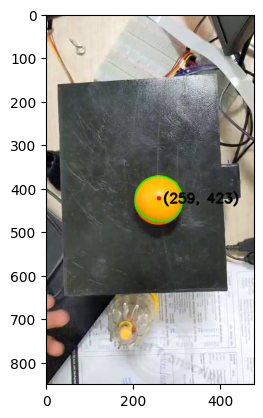

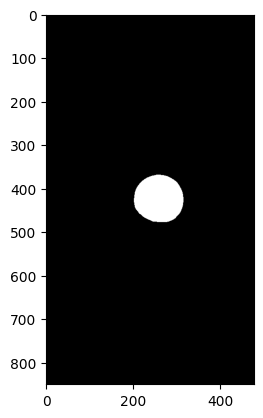

In [90]:
# unit test
import matplotlib.pyplot as plt
image = cv2.imread('frames/frame_16.jpg')
image, ball_masks, centroid = balls_segment(image, kernel_size=5, area_min=6000, area_max=10000)
# convert rgb to bgr
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image, cmap='gray')
plt.show()
plt.imshow(ball_masks, cmap='gray')
plt.show()

In [91]:
# video test
import cv2

cap = cv2.VideoCapture('ball_video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame, ball_masks, centroid = balls_segment(frame, kernel_size=5, area_min=6000, area_max=10000)
    cv2.imshow('frame', frame)
    cv2.imshow('ball_masks', ball_masks)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()